# Text Analysis

Text analysis is used to extract useful information from or summarize a large amount of unstructured text stored in documents. This opens up the opportunity of using text data alongside more conventional data sources (e.g. surveys and administrative data). The goal of text analysis is to take a large corpus of complex and unstructured text data and extract important and meaningful messages in a comprehensible way. 

Text analysis can help with the following tasks:

* **Information Retrieval**: Find relevant information in a large database, such as a systematic literature review, that would be very time-consuming for humans to do manually. 

* **Clustering and Text Categorization**: Summarize a large corpus of text by finding the most important phrases, using methods like topic modeling. 

* **Text Summarization**: Create category-sensitive text summaries of a large corpus of text. 

* **Machine Translation**: Translate documents from one language to another. 

In todays lab, we are going to analyze abstracts of grants using topic modeling to examine the content of our data and document classification to tag academic discipline in the abstracts. 

## Learning Outcomes

In this lab, you will...
* Learn how to transform a corpus of text into a structured matrix format so that we can apply natural language processing (NLP) methods
* Learn the basics and applications of topic modeling
* Learn how to do document tagging and evaluate the results

 
## Glossary of Terms

Glossary of Terms:

* **Corpus**: A corpus is the set of all text documents used in your analysis; for example, your corpus of text may include hundreds of research articles.

* **Tokenize**: Tokenization is the process by which text is separated into meaningful terms or phrases. In English this is easy to do for individual words, as they are separated by whitespace; however, it can get more complicated to  automate determining which groups of words constitute meaningful phrases. 

* **Stemming**: Stemming is normalizing text by reducing all forms or conjugations of a word to the word's most basic form. In English, this can mean making a rule of removing the suffixes "ed" or "ing" from the end of all words, but it gets more complex. For example, "to go" is irregular, so you need to tell the algorithm that "went" and "goes" stem from a common lemma, and should be considered alternate forms of the word "go."

* **TF-IDF**: TF-IDF (term frequency-inverse document frequency) is an example of feature engineering where the most important words are extracted by taking account their frequency in documents and the entire corpus of documents as a whole.

* **Topic Modeling**: Topic modeling is an unsupervised learning method where groups of words that often appear together are clustered into topics. Typically, the words in one topic should be related and make sense (e.g. boat, ship, captain). Individual documents can fall under one topic or multiple topics. 

* **LDA**: LDA (Latent Dirichlet Allocation) is a type of probabilistic model commonly used for topic modeling. 

* **Stop Words**: Stop words are words that have little semantic meaning but occur very frequently, like prepositions, articles and common nouns. For example, every document (in English) will probably contain the words "and" and "the" many times. You will often remove them as part of preprocessing using a list of stop words.


# Setup

In [1]:
%pylab inline 
import nltk
import json
import re
import time
import progressbar
import sqlalchemy
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from __future__ import print_function
from six.moves import zip, range 
from sklearn.model_selection import train_test_split
from sqlalchemy import create_engine

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_auc_score, auc
from sklearn import preprocessing
from collections import Counter, OrderedDict
from nltk.corpus import stopwords
from nltk import SnowballStemmer

import wordcloud 
from wordcloud import WordCloud

Populating the interactive namespace from numpy and matplotlib


In [2]:
nltk.download('stopwords') #download the latest stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /nfshome/deh341/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load the Data

To start, we'll load the data into a pandas DataFrame from our class database. The name and connection profile slightly changed after the move into the Cloud environment. Please keep this in mind for future work. We have one giant database on the new server for all projects available. Our class database is one schema in this giant database. Thus we connect to the cusp database now. When we select a table we need to make sure that we add the schema "wagner_ada_2018" so we end up with the correct table.

In [3]:
# create engine
engine = create_engine('postgresql://stuffed/cusp')

# create query 
QUERY = '''
SELECT *
FROM wagner_ada_2018.projects 
INNER JOiN wagner_ada_2018.abstracts 
ON wagner_ada_2018.projects.project_id = wagner_ada_2018.abstracts.project_id
LIMIT 5000 ;
'''

# save query in datafram
abstracts=pd.read_sql_query(QUERY,con=engine)

## Explore the Data
Our text data table has 2 fields:

- `project_id` - project ID.
- `abstract` - text of abstract.

Let's take a look at examples of the values:

In [4]:
# keep only variables needed and remove missing values
abstracts = abstracts[['abstract', 'fy_total_cost']]
abstracts = abstracts.dropna()

In [5]:
abstracts.head()

,abstract,fy_total_cost
0,The objective of this EArly-concept Grants for...,141557.0
1,Overview: This research will produce the secon...,295486.0
2,This doctoral dissertation research project in...,8820.0
3,"This is a large-scale (4,000 students, 32 teac...",1175214.0
4,The tarantula genus Aphonopelma ranks among th...,19240.0


# Explain underlying concept with example data

## Creating a matrix of features from text - Bag of N-gram Example

Ultimately, we want to take our collection of documents, corpus, and convert it into a matrix. Fortunately, `sklearn` has a pre-built object, `CountVectorizer`, that can tokenize, eliminate stopwords, identify n-grams, and stem our corpus, and output a matrix in one step. But we can also do this using this function. This is to show you what the `CountVectorizer` object from sklearn does in a minimal example

In [6]:
example_corpus = [ 'Here is the first entry in the list', 'This is the second entry in this list of entries', 
                  'Finally the last entry' ] 

In [7]:
def create_bag_of_words( corpus,
                         NGRAM_RANGE = ( 0, 1 ),
                         stop_words = None,
                         stem = False,
                         MIN_DF = 0.05,
                         MAX_DF = 0.95,
                         USE_IDF = False ):

    """
    Turn a corpus of text into a bag-of-words.
    
    Parameters
    -----------
    corpus: ls
        test of documents in corpus    
    NGRAM_RANGE: tuple
        range of N-gram. Default (0,1)
    stop_words: ls
        list of commonly occuring words that have little semantic
        value
    stem: bool
        use a stemmer to stem words
    MIN_DF: float
       exclude words that have a frequency less than the threshold
    MAX_DF: float
        exclude words that have a frequency greater than the threshold
    
    
    Returns
    -------
    bag_of_words: scipy sparse matrix
        scipy sparse matrix of text
    features:
        ls of words
    """
    #parameters for vectorizer 
    ANALYZER = "word" #unit of features are single words rather then phrases of words 
    STRIP_ACCENTS = 'unicode'
    stemmer = nltk.SnowballStemmer("english")

    if stem:
        tokenize = lambda x: [stemmer.stem(i) for i in x.split()]
    else:
        tokenize = None
    vectorizer = CountVectorizer(analyzer=ANALYZER,
                                tokenizer=tokenize, 
                                ngram_range=NGRAM_RANGE,
                                stop_words = stop_words,
                                strip_accents=STRIP_ACCENTS,
                                min_df = MIN_DF,
                                max_df = MAX_DF)
    
    bag_of_words = vectorizer.fit_transform( corpus ) #transform our corpus is a bag of words 
    features = vectorizer.get_feature_names()

    if USE_IDF:
        NORM = None #turn on normalization flag
        SMOOTH_IDF = True #prvents division by zero errors
        SUBLINEAR_IDF = True #replace TF with 1 + log(TF)
        transformer = TfidfTransformer(norm = NORM,smooth_idf = SMOOTH_IDF,sublinear_tf = True)
        #get the bag-of-words from the vectorizer and
        #then use TFIDF to limit the tokens found throughout the text 
        tfidf = transformer.fit_transform(bag_of_words)
        
        return tfidf, features
    else:
        return bag_of_words, features

In [8]:
# convert to bag of words
bag_of_words, features = create_bag_of_words( example_corpus )

In [9]:
# review - our corpus:
example_corpus

['Here is the first entry in the list',
 'This is the second entry in this list of entries',
 'Finally the last entry']

In [10]:
# features derived from the corpus
features

[u'entries',
 u'finally',
 u'first',
 u'here',
 u'in',
 u'is',
 u'last',
 u'list',
 u'of',
 u'second',
 u'this']

In [11]:
# bag of words that results:
np_bag_of_words = bag_of_words.toarray()
np_bag_of_words

array([[0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 2],
       [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]])

Our data has been transformed from a document into a 3 x 9 matrix, where each row in the matrix corresponds to a document, and each column corresponds to a feature (in the order they appear in `example_features`). A 1 indicates the existence of the feature or word in the document, and a 0 indicates the word is not present.

Our example corpus is now ready to be analyzed. We used this example to illustrate how a document is turned into a matrix to be used in text analysis. When you're applying this to real text data, the matrix will be much larger and harder to interpret, but it's important that you know the process. 

## Calculating Word Counts

As an initial look into the data, we can examine the most frequently occuring words in our corpus. We can sum the columns of the bag_of_words and then convert to a numpy array. From here we can zip the features and word_count into a dictionary, and display the results.

In [12]:
def get_word_counts( bag_of_words, feature_names ):

    """
    Get the ordered word counts from a bag_of_words
    
    Parameters
    ----------
    bag_of_words: obj
        scipy sparse matrix from CounterVectorizer
    feature_names: ls
        list of words
        
    Returns
    -------
    word_counts: dict
        Dictionary of word counts
    """

    # convert bag of words to array
    np_bag_of_words = bag_of_words.toarray()
    
    # calculate word count.
    word_count = np.sum(np_bag_of_words,axis=0)
    
    # convert to flattened array.
    np_word_count = np.asarray(word_count).ravel()
    
    # create dict of words mapped to count of occurrences of each word.
    dict_word_counts = dict( zip(feature_names, np_word_count) )
    
    # Create ordered dictionary
    orddict_word_counts = OrderedDict( sorted(dict_word_counts.items(), key=lambda x: x[1], reverse=True), )
    
    return orddict_word_counts

In [13]:
# get ordered word counts for our example corpus.
get_word_counts(bag_of_words, features)

OrderedDict([(u'this', 2),
             (u'is', 2),
             (u'list', 2),
             (u'in', 2),
             (u'last', 1),
             (u'of', 1),
             (u'entries', 1),
             (u'second', 1),
             (u'here', 1),
             (u'finally', 1),
             (u'first', 1)])

# Going back to the real Data

## Model topics with LDA

As a start to modeling topics, we define below a function "create_topics" that uses Latent Dirichlet Allocation (LDA) to find topics.

## Creating Text Corpus - choosing text to analyze

First we need to form our corpus, or the set of all descriptions from all abstracts. We can pull out the array of descriptions from the data frame using the data frame's `.values` attribute. 

In [14]:
# pull all the descriptions and put them in a numpy array
corpus = abstracts['abstract'].values  
corpus[0]

u'The objective of this EArly-concept Grants for Exploratory Research (EAGER) Program award is to perform research into a control-theoretic approach to robust design, appropriate for complex engineered system design. A robust design is a design possessing relatively invariant performance in the presence of various uncertainties. Current approaches to robust design are suitable primarily for designing established consumer products or updating existing system designs; these approaches are not appropriate for the design of large complex systems, such as spacecraft or smart grids, where primary uncertainties, such as environmental, budgeting, or new technology performance, are resolved in time. The research approach taken in this work treats the design process as a stochastic control problem in which the goal is to best align the system design for the current conditions and information available in a given time period. The design process is represented using a state-space model which is so

Create a bag of words and set of features from our abstract corpus:

In [15]:
corpus_bag_of_words, corpus_features = create_bag_of_words(corpus)

Let's examine our features. 

In [16]:
corpus_features

[u'000',
 u'10',
 u'12',
 u'ability',
 u'able',
 u'about',
 u'academic',
 u'access',
 u'achieve',
 u'across',
 u'action',
 u'activated',
 u'activation',
 u'active',
 u'activities',
 u'activity',
 u'acute',
 u'addition',
 u'additional',
 u'address',
 u'adult',
 u'advance',
 u'advanced',
 u'affect',
 u'after',
 u'against',
 u'age',
 u'agents',
 u'aim',
 u'aims',
 u'all',
 u'allow',
 u'also',
 u'although',
 u'among',
 u'an',
 u'analyses',
 u'analysis',
 u'analyze',
 u'animal',
 u'animals',
 u'anti',
 u'any',
 u'applicant',
 u'application',
 u'applications',
 u'approach',
 u'approaches',
 u'approximately',
 u'are',
 u'area',
 u'areas',
 u'as',
 u'aspects',
 u'assays',
 u'assess',
 u'assessment',
 u'associated',
 u'association',
 u'at',
 u'available',
 u'award',
 u'based',
 u'basic',
 u'basis',
 u'be',
 u'because',
 u'become',
 u'been',
 u'behavior',
 u'behavioral',
 u'being',
 u'benefit',
 u'better',
 u'between',
 u'binding',
 u'biochemical',
 u'biological',
 u'biology',
 u'blood',
 u'body

We can notice the words *activity* and *activities*, or the words *addition* and *additional*, are close enough to each other that it might not make sense to treat them as entirely separate words. Part of your cleaning and preprocessing duties will be manually inspecting your lists of features, seeing where these issues arise, and making decisions to either remove them from your analysis or address them separately. 

Let's get the count of the number of times that each of the words appears in our corpus.

In [17]:
get_word_counts( corpus_bag_of_words, corpus_features )

OrderedDict([(u'will', 17602),
             (u'for', 16078),
             (u'that', 15266),
             (u'is', 15261),
             (u'this', 11598),
             (u'with', 11559),
             (u'by', 11344),
             (u'are', 9275),
             (u'be', 8900),
             (u'we', 8790),
             (u'as', 8465),
             (u'on', 7667),
             (u'research', 6985),
             (u'these', 5995),
             (u'from', 5425),
             (u'an', 5421),
             (u'have', 5240),
             (u'or', 4599),
             (u'at', 4387),
             (u'our', 4251),
             (u'cells', 4202),
             (u'which', 4107),
             (u'cell', 3912),
             (u'specific', 3417),
             (u'project', 3390),
             (u'studies', 3357),
             (u'has', 3318),
             (u'development', 3305),
             (u'new', 3282),
             (u'health', 3198),
             (u'study', 3115),
             (u'cancer', 2973),
             (u'can', 2933)

Our top words are articles, prepositions and conjunctions that are not informative whatsoever, so we're probably not going to come up with anything interesting. 

These topics don't give us any real insight to what the data contains - one of the topics is "and, the, to, of, in". The signal is being swamped by the noise. We'll have to clean and process our data to get any meaningful information out of this text. 

## Text Cleaning and Normalization

To clean and normalize text, we'll remove all special characters, numbers, and punctuation, so we're left with only the words themselves. Then we will make all the text lowercase; this uniformity will ensure that the algorithm doesn't treat "the" and "The" as different words, for example. 

**Regular Expressions**, or "regexes" for short, let you find all the words or phrases in a document or text file that match a certain pattern. These rules are useful for pulling out useful information from a large amount of text. For example, if you want to find all email addresses in a document, you might look for everything that looks like *some combination of letters, _, .* followed by *@*, followed by more letters, and ending in *.com* or *.edu*. If you want to find all the credit card numbers in a document, you might look for everywhere you see the pattern "four numbers, space, four numbers, space, four numbers, space, four numbers." Regexes are also helpful if you are scraping information from websites, because you can use them to separate the content from the HTML code used for formatting the website.

For our purposes, we are going to use a regular expression to match all characters that are not letters -- punctuation, quotes, special characters and numbers -- and replace them with spaces. Then we'll make all of the remaining characters lowercase.  

We will be using the `re` library in python for regular expression matching.

In [18]:
#get rid of the punctuations and set all characters to lowercase
RE_PREPROCESS = re.compile( r'\W+|\d+' ) #the regular expressions that matches all non-characters

#get rid of punctuation and make everything lowercase
#the code below works by looping through the array of text ("corpus")
#for a given piece of text ( "description" ) we invoke the `re.sub` command 
#the `re.sub` command takes 3 arguments: (1) the regular expression to match, 
#(2) what we want to substitute in place of that matching string (' ', a space)
#and (3) the text we want to apply this to. 
#we then invoke the `lower()` method on the output of the `re.sub` command
#to make all the remaining characters lowercase.
#the result is a list, where each entry in the list is a cleaned version of the
#corresponding entry in the original corpus.
#we then make the list into a numpy array to use it in analysis

processed_corpus = np.array( [ re.sub( RE_PREPROCESS, ' ', description ).lower() for description in corpus ] )

Next, let's look at an example of the results of this cleanup.

In [19]:
processed_corpus[0]

u'the objective of this early concept grants for exploratory research eager program award is to perform research into a control theoretic approach to robust design appropriate for complex engineered system design a robust design is a design possessing relatively invariant performance in the presence of various uncertainties current approaches to robust design are suitable primarily for designing established consumer products or updating existing system designs these approaches are not appropriate for the design of large complex systems such as spacecraft or smart grids where primary uncertainties such as environmental budgeting or new technology performance are resolved in time the research approach taken in this work treats the design process as a stochastic control problem in which the goal is to best align the system design for the current conditions and information available in a given time period the design process is represented using a state space model which is solved using kal

All lowercase, all numbers and special characters have been removed. Out text is now normalized.

## Tokenizing text - breaking it into pieces

Now that we've cleaned our text, we can *tokenize* it by deciding which words or phrases are the most meaningful. Normally the `CountVectorizer` handles this for us, but in this case, we'll split our text into individual words manually to show how it is done.

To go from a whole document to a list of individual words, we can use the `.split()` command. By default, this command splits based on spaces in between words, so we don't need to specify that explicitly.  

In [20]:
tokens = processed_corpus[0].split()

In [21]:
tokens

[u'the',
 u'objective',
 u'of',
 u'this',
 u'early',
 u'concept',
 u'grants',
 u'for',
 u'exploratory',
 u'research',
 u'eager',
 u'program',
 u'award',
 u'is',
 u'to',
 u'perform',
 u'research',
 u'into',
 u'a',
 u'control',
 u'theoretic',
 u'approach',
 u'to',
 u'robust',
 u'design',
 u'appropriate',
 u'for',
 u'complex',
 u'engineered',
 u'system',
 u'design',
 u'a',
 u'robust',
 u'design',
 u'is',
 u'a',
 u'design',
 u'possessing',
 u'relatively',
 u'invariant',
 u'performance',
 u'in',
 u'the',
 u'presence',
 u'of',
 u'various',
 u'uncertainties',
 u'current',
 u'approaches',
 u'to',
 u'robust',
 u'design',
 u'are',
 u'suitable',
 u'primarily',
 u'for',
 u'designing',
 u'established',
 u'consumer',
 u'products',
 u'or',
 u'updating',
 u'existing',
 u'system',
 u'designs',
 u'these',
 u'approaches',
 u'are',
 u'not',
 u'appropriate',
 u'for',
 u'the',
 u'design',
 u'of',
 u'large',
 u'complex',
 u'systems',
 u'such',
 u'as',
 u'spacecraft',
 u'or',
 u'smart',
 u'grids',
 u'where',


## Removing meaningless text - Stopwords

Stopwords are words that are found commonly throughout a text and carry little semantic meaning. Examples of common stopwords are prepositions ("to", "on", "in"), articles ("the", "an", "a"), conjunctions ("and", "or", "but") and common nouns. For example, the words *the* and *of* are totally ubiquitous, so they won't serve as meaningful features, whether to distinguish documents from each other or to tell what a given document is about. You may also run into words that you want to remove based on where you obtained your corpus of text or what it's about. There are many lists of common stopwords available for you to use, both for general documents and for specific contexts, so you don't have to start from scratch.   

We can eliminate stopwords by checking all the words in our corpus against a list of commonly occuring stopwords that comes with NLTK.

In [22]:
eng_stopwords = stopwords.words('english')

In [23]:
#sample of stopwords
#this is an example of slicing where we implicitly start at the beginning and move to the end
#we select every 10th entry in the array
eng_stopwords[::10]

[u'i',
 u"you've",
 u'himself',
 u'they',
 u'that',
 u'been',
 u'a',
 u'while',
 u'through',
 u'in',
 u'here',
 u'few',
 u'own',
 u'just',
 u're',
 u'doesn',
 u'ma',
 u"shouldn't"]

Notice that this list includes "weren" and "hasn" as well as single letters ("t"). 

##  Topic Modeling on Cleaned Data

Now that we've cleaned up our data a little bit, let's see what our bag of words looks like.

In [24]:
# create bag of words from processed_corpus
processed_bag_of_words, processed_features = create_bag_of_words( processed_corpus, stop_words = eng_stopwords )
dict_processed_word_counts = get_word_counts( processed_bag_of_words, processed_features )
dict_processed_word_counts

OrderedDict([(u'research', 6986),
             (u'cells', 4203),
             (u'cell', 3912),
             (u'specific', 3417),
             (u'project', 3396),
             (u'studies', 3357),
             (u'development', 3305),
             (u'new', 3282),
             (u'health', 3198),
             (u'study', 3115),
             (u'cancer', 2973),
             (u'data', 2863),
             (u'aim', 2844),
             (u'provided', 2824),
             (u'disease', 2669),
             (u'applicant', 2647),
             (u'also', 2641),
             (u'description', 2634),
             (u'use', 2632),
             (u'clinical', 2607),
             (u'program', 2497),
             (u'using', 2342),
             (u'provide', 2237),
             (u'human', 2231),
             (u'based', 2175),
             (u'treatment', 2111),
             (u'determine', 2082),
             (u'understanding', 2050),
             (u'patients', 2046),
             (u'mechanisms', 2032),
             (u

Much better! Now this is starting to look like a reasonable representation of our corpus of text. 

We mentioned that, in addition to stopwords that are common across all types of text analysis problems, there wil also be specific stopwords based on the context of your domain. 

One quick way to remove some of these domain-specific stopwords is by dropping some of your most frequent words. We'll start out by dropping the top 20. You'll want to change this number, playing with making it bigger and smaller, to see how it affects your resulting topics.

In [25]:
# get top 20 stopwords (slice from start through 20 items in list)
top_20_words = list(dict_processed_word_counts.keys())[:20]

# create new stopword list by combining default stopwords with our top 20.
domain_specific_stopwords = eng_stopwords + top_20_words

# make a new bag of words excluding custom stopwords.
processed_bag_of_words, processed_features = create_bag_of_words(processed_corpus,
                                                                 stop_words=domain_specific_stopwords)

In [26]:
# what do we have now?
dict_processed_word_counts = get_word_counts(processed_bag_of_words, processed_features)
dict_processed_word_counts

OrderedDict([(u'program', 2497),
             (u'using', 2342),
             (u'provide', 2237),
             (u'human', 2231),
             (u'based', 2175),
             (u'treatment', 2111),
             (u'determine', 2082),
             (u'understanding', 2050),
             (u'patients', 2046),
             (u'mechanisms', 2032),
             (u'function', 2015),
             (u'well', 1960),
             (u'role', 1896),
             (u'may', 1869),
             (u'training', 1866),
             (u'proposed', 1864),
             (u'high', 1863),
             (u'develop', 1860),
             (u'protein', 1843),
             (u'model', 1837),
             (u'molecular', 1829),
             (u'novel', 1781),
             (u'two', 1765),
             (u'expression', 1731),
             (u'system', 1721),
             (u'important', 1706),
             (u'associated', 1660),
             (u'including', 1652),
             (u'risk', 1641),
             (u'gene', 1628),
             (u

This is a bit better - although we still see some words that are probably very common.

(-0.5, 399.5, 199.5, -0.5)

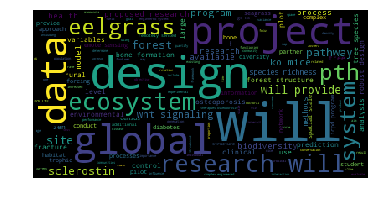

In [27]:
# some fun stuff: a word cloud from all the words in our processed corpus
abstract_list =str(processed_corpus)
cloud = WordCloud().generate(abstract_list)

# Display the generated image (this uses matplotlib)
plt.imshow(cloud)
plt.axis("off")

#### Now we can start creating topics

In [28]:
def create_topics(tfidf, features, N_TOPICS=3, N_TOP_WORDS=5,):
    """
    Given a matrix of features of text data generate topics
    
    Parameters
    -----------
    tfidf: scipy sparse matrix
        sparse matrix of text features
    N_TOPICS: int
        number of topics (default 10)
    N_TOP_WORDS: int
        number of top words to display in each topic (default 10)
        
    Returns
    -------
    ls_keywords: ls
        list of keywords for each topics
    doctopic: array
        numpy array with percentages of topic that fit each category
    N_TOPICS: int
        number of assumed topics
    N_TOP_WORDS: int
        Number of top words in a given topic. 
    """
    
    with progressbar.ProgressBar(max_value=progressbar.UnknownLength) as bar:
        i=0
        lda = LatentDirichletAllocation( n_topics= N_TOPICS,
                                       learning_method='online') #create an object that will create 5 topics
        bar.update(i)
        i+=1
        doctopic = lda.fit_transform( tfidf )
        bar.update(i)
        i+=1
        
        ls_keywords = []
        for i,topic in enumerate(lda.components_):
            word_idx = np.argsort(topic)[::-1][:N_TOP_WORDS]
            keywords = ', '.join( features[i] for i in word_idx)
            ls_keywords.append(keywords)
            print(i, keywords)
            bar.update(i)
            i+=1
            
    return ls_keywords, doctopic

In [29]:
# in general woth no restrictions
processed_keywords, processed_doctopic = create_topics(processed_bag_of_words, processed_features)

| 2 Elapsed Time: 0:00:15                                                      


0 treatment, patients, risk, based, children
1 program, training, students, science, university
2 protein, mechanisms, human, function, expression


We can manipulate the number of topics we want to find and the number of words to use for each topic to see if we can understand more from our corpus. 

In [30]:
# look for 5 topics, include 10 words in each.
processed_keywords, processed_doctopic = create_topics(processed_bag_of_words, 
                                                       processed_features, 
                                                       N_TOPICS = 5,
                                                       N_TOP_WORDS= 10)

| 4 Elapsed Time: 0:00:20                                                      


0 risk, treatment, children, intervention, based, patients, care, outcomes, social, proposed
1 role, mice, mechanisms, brain, determine, activation, signaling, function, hypothesis, induced
2 program, training, students, science, university, center, support, provide, community, faculty
3 patients, tumor, human, infection, treatment, genetic, therapy, drug, novel, using
4 protein, proteins, molecular, function, understanding, gene, human, complex, genes, mechanisms


Now let's try 10 topics with 15 words each:

In [31]:
# 10 topics, 15 words each
processed_keywords, processed_doctopic = create_topics(processed_bag_of_words, 
                                                       processed_features, 
                                                       N_TOPICS = 10,
                                                       N_TOP_WORDS= 15)

| 9 Elapsed Time: 0:00:20                                                      


0 signaling, role, mice, mechanisms, determine, activation, immune, induced, receptor, function, expression, hypothesis, response, mouse, model
1 program, training, center, university, support, community, dr, faculty, programs, core, career, provide, investigators, biology, scientists
2 brain, neurons, cognitive, neural, functional, disorders, changes, mechanisms, behavioral, function, activity, processing, understanding, behavior, regions
3 human, information, chemical, stress, tools, develop, natural, site, public, used, species, drugs, methods, molecules, products
4 protein, gene, genes, proteins, genetic, dna, expression, molecular, function, human, identify, binding, genome, complex, cellular
5 system, systems, model, energy, understanding, design, methods, high, structure, models, work, processes, large, time, properties
6 risk, children, factors, effects, women, among, social, related, age, associated, exposure, may, population, outcomes, intervention
7 students, science, school

This looks like a good amount of topics for now. Some of the top words are quite similar, like "volunteer" and "volunteers," or "child" and "children." Let's move to stemming and lemmatization.

## Stemming and Lemmatization - Distilling text data

We can further process our text through *stemming and lemmatization*, or replacing words with their root or simplest form. For example "systems," "systematic," and "system" are all different words, but we can replace all these words with "system" without sacrificing much meaning. 

- A **lemma** is the original dictionary form of a word (e.g. the lemma for "lies," "lied," and "lying" is "lie").
- The process of turning a word into its simplest form is **stemming**. There are several well known stemming algorithms -- Porter, Snowball, Lancaster -- that all have their respective strengths and weaknesses.

For this tutorial, we'll use the Snowball Stemmer:

In [32]:
# Examples of how a Stemmer works:
stemmer = SnowballStemmer("english")
print(stemmer.stem('lies'))
print(stemmer.stem("lying"))
print(stemmer.stem('systematic'))
print(stemmer.stem("running"))

lie
lie
systemat
run


Let's try creating a bag of stemmed words.

In [33]:
# include stemming when creating our bag of words.
processed_bag_of_words, processed_features = create_bag_of_words(processed_corpus,
                                                                 stop_words=domain_specific_stopwords,
                                                                 stem=True)

In [34]:
# create topics with stemmed words.
processed_keywords, processed_doctopic = create_topics(processed_bag_of_words, 
                                                       processed_features, 
                                                       N_TOPICS = 10,
                                                       N_TOP_WORDS= 15)

| 9 Elapsed Time: 0:00:25                                                      


0 gene, genet, express, identifi, dna, diseas, genom, develop, human, specif, studi, transcript, mutat, function, regul
1 activ, signal, mechan, regul, role, respons, specif, receptor, function, immun, studi, determin, protein, pathway, diseas
2 protein, structur, function, studi, complex, process, understand, develop, provid, propos, biolog, interact, system, applic, model
3 patient, treatment, drug, effect, studi, clinic, therapi, develop, diseas, provid, applic, therapeut, potenti, propos, injuri
4 brain, behavior, neuron, function, chang, cognit, disord, understand, process, neural, studi, propos, provid, activ, relat
5 program, train, provid, clinic, center, support, student, career, year, univers, develop, mentor, applic, dr, faculti
6 develop, student, communiti, model, scienc, comput, educ, materi, impact, engin, system, design, includ, high, univers
7 develop, clinic, imag, provid, applic, method, phase, system, technolog, improv, test, base, detect, propos, perform
8 tumor, p

What do we think of these topics?

## N-grams - Adding context by creating N-grams

Obviously, reducing a document to a bag of words means losing much of its meaning - we put words in certain orders, and group words together in phrases and sentences, precisely to give them more meaning. If you follow the processing steps we've gone through so far, splitting your document into individual words and then removing stopwords, you'll completely lose all phrases like "kick the bucket," "commander in chief," or "sleeps with the fishes." 

One way to address this is to break down each document similarly, but rather than treating each word as an individual unit, treat each group of 2 words, or 3 words, or *n* words, as a unit. We call this a "bag of *n*-grams," where *n* is the number of words in each chunk. Then you can analyze which groups of words commonly occur together (in a fixed order). 

Let's transform our corpus into a bag of n-grams with *n*=2: a bag of 2-grams, AKA a bag of bi-grams.

In [35]:
# create bag of words with stemmed words and 2-grams (NGRAM_RANGE = (0, 2)).
processed_bag_of_words, processed_features = create_bag_of_words(processed_corpus,
                                                                 stop_words=domain_specific_stopwords,
                                                                 stem=True,
                                                                 NGRAM_RANGE=(0,2))

In [36]:
# Create topics.
processed_keywords, processed_doctopic = create_topics(processed_bag_of_words, 
                                                       processed_features, 
                                                       N_TOPICS = 10,
                                                       N_TOP_WORDS= 15)

| 9 Elapsed Time: 0:00:26                                                      


0 respons, immun, activ, infect, mechan, induc, diseas, effect, model, mice, studi, determin, increas, injuri, specif
1 program, train, student, provid, scienc, univers, center, support, develop, year, clinic, career, includ, institut, mentor
2 studi, measur, high, chang, differ, time, model, method, result, effect, sampl, e, test, level, g
3 studi, risk, age, associ, factor, diseas, genet, identifi, popul, children, relat, individu, develop, exposur, provid
4 develop, system, model, comput, technolog, design, materi, process, base, tool, impact, inform, method, understand, provid
5 intervent, studi, treatment, effect, patient, provid, care, outcom, prevent, behavior, improv, trial, clinic, base, test
6 protein, structur, function, dna, complex, genom, interact, bind, understand, provid, sequenc, membran, studi, molecular, propos
7 clinic, patient, develop, drug, treatment, tumor, therapi, imag, applic, diseas, specif, studi, target, provid, therapeut
8 gene, regul, express, signal, ac

We can see that this lets us uncover patterns that we couldn't when we just used a bag of words. Note that this still includes the individual words, as well as the bi-grams.

## TF-IDF - Weighting terms based on frequency

A final step in cleaning and processing our text data is **Term Frequency-Inverse Document Frequency (TF-IDF)**. TF-IDF is based on the idea that the words (or terms) that are most related to a certain topic will occur frequently in documents on that topic, and infrequently in unrelated documents.  TF-IDF re-weights words so that we emphasize words that are unique to a document and suppress words that are common throughout the corpus by inversely weighting terms based on their frequency within the document and across the corpus.

Let's look at how using TF-IDF affects our bag of words:

In [37]:
# create bag of words including TF-IDF weighting.
processed_bag_of_words, processed_features = create_bag_of_words( processed_corpus,
                                                                  stop_words = domain_specific_stopwords,
                                                                  stem = True,
                                                                  NGRAM_RANGE = ( 0, 2 ),
                                                                  USE_IDF = True )

In [38]:
# let's see what we have:
dict_word_counts = get_word_counts( processed_bag_of_words, processed_features )
dict_word_counts

OrderedDict([(u'develop', 6575.4592134307886),
             (u'studi', 6558.7775025359142),
             (u'provid', 5839.8552113242295),
             (u'propos', 5495.7692387464549),
             (u'activ', 5264.2454080248481),
             (u'specif', 5226.7213103133918),
             (u'function', 5154.9097597809468),
             (u'applic', 4991.3183957030178),
             (u'diseas', 4946.495760742494),
             (u'effect', 4839.194827429289),
             (u'model', 4744.7904359071672),
             (u'mechan', 4741.2533897188605),
             (u'includ', 4451.9875470296356),
             (u'understand', 4434.7338335049189),
             (u'program', 4411.1538513280448),
             (u'clinic', 4363.9985534215239),
             (u'determin', 4358.0430283450714),
             (u'system', 4333.9089133610714),
             (u'protein', 4277.0996499674002),
             (u'identifi', 4242.9244273971835),
             (u'gene', 4146.9740940984739),
             (u'human', 4143

The words counts have been reweighted to emphasize the more meaningful words of the corpus, while de-emphasizing the words that are found commonly throughout the corpus.

How does this affect our topics?

In [39]:
processed_keywords, processed_doctopic = create_topics(processed_bag_of_words, 
                                                       processed_features, 
                                                       N_TOPICS = 10,
                                                       N_TOP_WORDS= 15)

| 9 Elapsed Time: 0:00:27                                                      


0 brain, neuron, cognit, behavior, disord, neural, function, age, impair, chang, learn, understand, process, examin, region
1 gene, protein, genet, regul, genom, dna, express, function, transcript, identifi, molecular, mutat, sequenc, gene express, interact
2 intervent, patient, trial, risk, clinic, treatment, outcom, care, children, studi, prevent, effect, year, clinic trial, age
3 structur, properti, chemic, comput, process, energi, complex, system, fundament, model, dynam, problem, mani, natur, understand
4 train, program, mentor, career, dr, faculti, center, univers, core, medicin, scientist, clinic, support, translat, year
5 student, communiti, educ, program, scienc, nation, school, undergradu, univers, support, institut, particip, graduat, collabor, servic
6 imag, detect, technolog, method, monitor, phase, resolut, develop, perform, capabl, improv, optim, valid, high, techniqu
7 receptor, signal, tumor, activ, induc, inhibit, pathway, mice, mechan, therapeut, target, regul, media

# Supervised Learning: Document Classification

Previously, we used topic modeling to infer relationships of abstracts of funded research projects. That is an example of unsupervised learning: we were looking to uncover structure in the form of topics, or groups of agencies, but we did not necessarily know the ground truth of how many groups we should find or which agencies belonged in which group.  

Now we turn our attention to supervised learning. In supervised learning, we have a *known* outcome or label (*Y*) that we want to produce given some data (*X*), and in general, we want to be able to produce this *Y* when we *don't* know it, or when we *only* have *X*. 

In order to produce labels we need to first have examples our algorithm can learn from, a "training set." In the context of text analysis, developing a training set can be very expensive, as it can require a large amount of human labor or linguistic expertise. **Document classification** is an example of supervised learning in which want to characterize our documents based on their contents (*X*). A common example of document classification is spam e-mail detection. Another example of supervised learning in text analysis is *sentiment analysis*, where *X* is our documents and *Y* is the state of the author. This "state" is dependent on the question you're trying to answer, and can range from the author being happy or unhappy with a product to the author being politically conservative or liberal. Another example is *part-of-speech tagging* where *X* are individual words and *Y* is the part-of-speech. 

In this section, we'll train a classifier to classify abstract of grant proposals. Let's see if we can label a new abstract as belonging to a high paying research grant or low paying grant"

## Supervised Learning - Prepare the Data

In [40]:
# make a mask column we can use to flag rows with facility type in our types of interest.
abstracts['value'] = np.where((abstracts['fy_total_cost'] >= 100000) , 'High', 'Low')

In [41]:
abstracts.head()

,abstract,fy_total_cost,value
0,The objective of this EArly-concept Grants for...,141557.0,High
1,Overview: This research will produce the secon...,295486.0,High
2,This doctoral dissertation research project in...,8820.0,Low
3,"This is a large-scale (4,000 students, 32 teac...",1175214.0,High
4,The tarantula genus Aphonopelma ranks among th...,19240.0,Low


Split into training and testing sets (20% held back for training):

In [42]:
# split into train and test sets.
df_train, df_test = train_test_split(abstracts, test_size=0.20, random_state=17)

Look at our training set:

In [43]:
# look at our training set.
df_train.head()

,abstract,fy_total_cost,value
294,This research project will examine how prenata...,400000.0,High
2790,Previously we developed conditions for EC cell...,53351.0,Low
1101,DEVELOPMENT OF BIOPORES IN THE SUBSURFACE BY B...,220678.0,High
3623,DESCRIPTION (provided by applicant): We estima...,135001.0,High
4563,DESCRIPTION (provided by applicant): Fibrocart...,360000.0,High


In [44]:
# make sure we only have the facility types we expect.
df_train['value'].unique()

array(['High', 'Low'], dtype=object)

In [45]:
# look at the counts for each value.
Counter(df_train['value'].values)

Counter({'High': 2651, 'Low': 583})

Look at our testing set:

In [46]:
# look at our testing set.
df_test.head()

,abstract,fy_total_cost,value
3402,A hallmark of Type 2 diabetes is impaired insu...,268121.0,High
1763,DESCRIPTION (provided by applicant): Heart val...,353112.0,High
3472,DESCRIPTION (provided by applicant): This is a...,737428.0,High
3903,DESCRIPTION (provided by applicant): Diversifi...,278705.0,High
3508,Previous studies show that activation and supp...,477861.0,High


In [47]:
# make sure we only have the facility types we expect.
df_test['value'].unique()

array(['High', 'Low'], dtype=object)

In [48]:
# look at the counts for each value.
Counter(df_test['value'].values)

Counter({'High': 666, 'Low': 143})

## Prepare Data for Document Classification

In order to feed out data into a classifier, we need to pull out the labels (*Y*) and a clean corpus of documents (*X*) for our training and testing sets. 

In [49]:
# prepare training data - get labels we'll train on.
train_labels = df_train.value.values

# prepare training data - clean text.
train_corpus = np.array( [re.sub(RE_PREPROCESS, ' ', text).lower() for text in df_train.abstract.values])

# prepare testing data - get labels we'll train on.
test_labels = df_test.value.values

# prepare testing data - clean text.
test_corpus = np.array( [re.sub(RE_PREPROCESS, ' ', text).lower() for text in df_test.abstract.values])

# make list of all labels across train and test (should just be 'income' and 'health')
labels = np.append(train_labels, test_labels)

Just as we had done in the unsupervised learning context, we have to transform our data. This time we have to transform our testing and training set into two different bags of words. The classifier will learn from the training set, and we will evaluate the classifier's performance on the testing set.

First, we create a CountVectorizer that we'll use to convert our text documents to matrices of features based on words contained within our corpus.

In [50]:
#parameters for vectorizer 
ANALYZER = "word" #unit of features are single words rather then phrases of words 
STRIP_ACCENTS = 'unicode'
TOKENIZER = None
NGRAM_RANGE = (0,2) #Range for pharases of words
MIN_DF = 0.01 # Exclude words that have a frequency less than the threshold
MAX_DF = 0.8  # Exclude words that have a frequency greater then the threshold 

vectorizer = CountVectorizer( analyzer = ANALYZER,
                              tokenizer = None, # alternatively tokenize_and_stem but it will be slower 
                              ngram_range = NGRAM_RANGE,
                              stop_words = stopwords.words( 'english' ),
                              strip_accents = STRIP_ACCENTS,
                              min_df = MIN_DF,
                              max_df = MAX_DF )

Next, we create a TF-IDF transformer, and create our bags of words, then weight them using TF-IDF.

In [51]:
NORM = None          # turn on normalization flag
SMOOTH_IDF = True    # prevents division by zero errors
SUBLINEAR_IDF = True # replace TF with 1 + log(TF)
USE_IDF = True       # flag to control whether to use TFIDF

transformer = TfidfTransformer( norm = NORM,
                                smooth_idf = SMOOTH_IDF,
                                sublinear_tf = True )

# timing code - start!
start_time = time.time()

# get the bag-of-words for train and test from the vectorizer and
# then use TFIDF to limit the tokens found throughout the text 
train_bag_of_words = vectorizer.fit_transform( train_corpus ) #using all the data on for generating features!! Bad!
test_bag_of_words = vectorizer.transform( test_corpus )

# if we use IDF, compute it here.
if USE_IDF:
    train_tfidf = transformer.fit_transform(train_bag_of_words)
    test_tfidf = transformer.transform(test_bag_of_words)

# Get list of the feature names, for passing to our model.
features = vectorizer.get_feature_names()

# timing code - done!
print('Time Elapsed: {0:.2f}s'.format( time.time() - start_time ) )

Time Elapsed: 5.80s


We cannot pass the labels "income" or "health" directly to the classifier. Instead, we to encode them as 0s and 1s using the `labelencoder` part of `sklearn`. 

In [52]:
#relabel our labels as a 0 or 1
le = preprocessing.LabelEncoder() 
le.fit(labels)
labels_binary = le.transform(labels)

In [53]:
list(zip(labels,labels_binary))

[('High', 0),
 ('Low', 1),
 ('High', 0),
 ('High', 0),
 ('High', 0),
 ('High', 0),
 ('High', 0),
 ('High', 0),
 ('High', 0),
 ('High', 0),
 ('High', 0),
 ('High', 0),
 ('High', 0),
 ('High', 0),
 ('Low', 1),
 ('High', 0),
 ('High', 0),
 ('High', 0),
 ('High', 0),
 ('Low', 1),
 ('High', 0),
 ('High', 0),
 ('Low', 1),
 ('High', 0),
 ('High', 0),
 ('High', 0),
 ('Low', 1),
 ('High', 0),
 ('High', 0),
 ('Low', 1),
 ('High', 0),
 ('High', 0),
 ('Low', 1),
 ('High', 0),
 ('Low', 1),
 ('High', 0),
 ('Low', 1),
 ('High', 0),
 ('High', 0),
 ('High', 0),
 ('High', 0),
 ('Low', 1),
 ('High', 0),
 ('High', 0),
 ('High', 0),
 ('High', 0),
 ('High', 0),
 ('High', 0),
 ('High', 0),
 ('High', 0),
 ('High', 0),
 ('High', 0),
 ('High', 0),
 ('High', 0),
 ('High', 0),
 ('High', 0),
 ('High', 0),
 ('High', 0),
 ('High', 0),
 ('High', 0),
 ('Low', 1),
 ('High', 0),
 ('High', 0),
 ('Low', 1),
 ('High', 0),
 ('High', 0),
 ('High', 0),
 ('Low', 1),
 ('High', 0),
 ('Low', 1),
 ('High', 0),
 ('High', 0),
 ('Hig

We also need to create arrays of indices so we can access the training and testing sets accordingly.

In [54]:
train_size = df_train.shape[ 0 ]
train_set_idx = np.arange( 0, train_size )
test_set_idx = np.arange( train_size, len( labels ) )
train_labels_binary = labels_binary[ train_set_idx ]
test_labels_binary = labels_binary[ test_set_idx ]

## Model Training - Train Document Classification Model

The classifier we are using in the example is LogisticRegression. As we saw in the Machine Learning tutorial, first we decide on a classifier, then we fit the classifier to the data to create a model. We can then test our model on the test set by passing the features (*X*) from our test set to get predicted labels. The model will output the probability of each document being classified as income or health. 

In [55]:
# create our LogisticRegression classifier.
clf = LogisticRegression(penalty='l1')

# train the classifer to create our model.
mdl = clf.fit( train_tfidf, labels_binary[ train_set_idx ] )

# create scores for each of the documents predicting whether each refers to 
#     an income or health agency
y_score = mdl.predict_proba( test_tfidf )

## Model Evaluation - Precision and Recall

Now that we have calculated a score for each of our facility types of interest, we look at how well our model performed by outputting precision and recall curves at different cutoffs.

First, we define the function that will do this work:

In [56]:
def plot_precision_recall_n( y_true, y_prob, model_name ):

    """
    y_true: ls
        ls of ground truth labels
    y_prob: ls
        ls of predic proba from model
    model_name: str
        str of model name (e.g, LR_123)
    """
    
    from sklearn.metrics import precision_recall_curve
    
    y_score = y_prob
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_score)
    precision_curve = precision_curve[:-1]
    recall_curve = recall_curve[:-1]
    pct_above_per_thresh = []
    number_scored = len(y_score)
    for value in pr_thresholds:
        num_above_thresh = len(y_score[y_score>=value])
        pct_above_thresh = num_above_thresh / float(number_scored)
        pct_above_per_thresh.append(pct_above_thresh)
    pct_above_per_thresh = np.array(pct_above_per_thresh)
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(pct_above_per_thresh, precision_curve, 'b')
    ax1.set_xlabel('percent of population')
    ax1.set_ylabel('precision', color='b')
    ax1.set_ylim(0,1.05)
    ax2 = ax1.twinx()
    ax2.plot(pct_above_per_thresh, recall_curve, 'r')
    ax2.set_ylabel('recall', color='r')
    ax2.set_ylim(0,1.05)
    
    name = model_name
    plt.title(name)
    plt.show()

Then we output the graphs for our model:

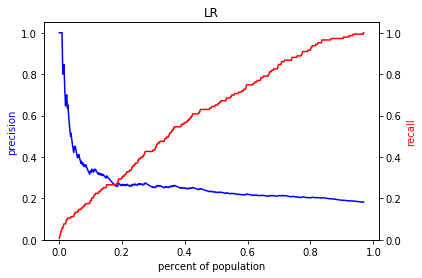

In [57]:
 plot_precision_recall_n( labels_binary[ test_set_idx ], y_score[:,1], 'LR' )

Alternatively, we can try to maximize the entire precision-recall space. In this case we need a different metric - "Area Under Curve" (AUC). 

In [58]:
def plot_precision_recall(y_true,y_score):
    """
    Plot a precision recall curve
    
    Parameters
    ----------
    y_true: ls
        ground truth labels
    y_score: ls
        score output from model
    """
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true,y_score[:,1])
    plt.plot(recall_curve, precision_curve)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    auc_val = auc(recall_curve,precision_curve)
    print('AUC-PR: {0:1f}'.format(auc_val))
    plt.show()
    plt.clf()

AUC-PR: 0.322680


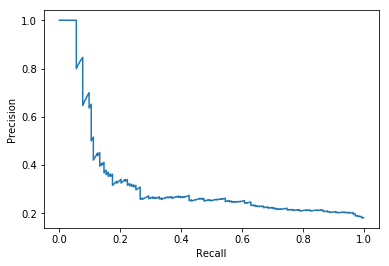

In [59]:
plot_precision_recall(labels_binary[test_set_idx],y_score)

 The AUC shows how accurate our scores are under different cutoff thresholds. The model will output a score between 0 and 1. We specify a  range of cutoff values and label all of the examples as 0 or 1 based on whether they are above or below each cutoff value. The closer our scores are to the true values, the more resilient they are to different cutoffs. For instance, if our scores were perfect, our AUC would be 1. 

## Model Evaluation - Feature Importances

Next, we look at the importance of different features (words) in our model.

The function that will calculate these:

In [60]:
def display_feature_importances( coef, features, labels, num_features = 10 ):

    """
    output feature importances
    
    Parameters
    ----------
    coef: numpy
        feature importances
    features: ls 
        feature names
    labels: ls
        labels for the classifier
    num_features: int
        number of features to output (default 10)
    
    Example
    --------
    
    
    """
    coef = mdl.coef_.ravel()

    dict_feature_importances = dict( zip(features, coef) )
    orddict_feature_importances = OrderedDict( 
                                    sorted(dict_feature_importances.items(), key=lambda x: x[1]) )

    ls_sorted_features  = list(orddict_feature_importances.keys())

    label0_features = ls_sorted_features[:num_features] 
    label1_features = ls_sorted_features[-num_features:] 

    print(labels[0],label0_features)
    print(labels[1], label1_features)

In [61]:
display_feature_importances(mdl.coef_.ravel(), features, ['high','low'])

high [u'immunological', u'drive', u'turn', u'medication', u'examine whether', u'research team', u'true', u'used identify', u'channel', u'drug use']
low [u'student', u'correlation', u'performed', u'washington', u'age related', u'goal research', u'received', u'acquired', u'basal', u'collaborations']


The feature importances give us the words which are the most relevant for distinguishing the type of grant (between high or low funded grant). Some of these make sense, but some don't make as much sense, or seem to be artifacts that we should remove. 

# Further Resources

A great resource for NLP in Python is 
[Natural Language Processing with Python](https://www.amazon.com/Natural-Language-Processing-Python-Analyzing/dp/0596516495).